In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pypsa

idx = pd.IndexSlice

In [5]:
days = pd.date_range('2022-01-01', '2025-01-01').strftime('%Y-%m-%d')

In [6]:
pns, bids = [], []

In [12]:
for day in tqdm(days):

    try:
        new_pn = pd.read_csv(
            Path.cwd().parent / 'data' / 'base' / f'{day}' / 'physical_notifications.csv',
            index_col=0,
            parse_dates=True
            )
    except FileNotFoundError:
        continue

    try:
        new_bids = pd.read_csv(
            Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv',
            index_col=[0,1],
            parse_dates=[0]
            )
    except FileNotFoundError:
        continue

    pns.append(new_pn)
    bids.append(new_bids)

100%|██████████| 1097/1097 [00:45<00:00, 23.90it/s]


In [28]:
pns_df = pd.concat(pns)
bids_df = pd.concat(bids)

bids_df = (bids_df.loc[idx[:,'vol'],:] * 2).replace(np.nan, 0.)
bids_df.index = bids_df.index.get_level_values(0)

In [19]:
roc = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'roc_values.csv', index_col=0)['roc_value']
cfd = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'cfd_strike_prices.csv', index_col=0)

cfd.columns = pd.to_datetime(cfd.columns)
cfd = cfd.iloc[:,-1]

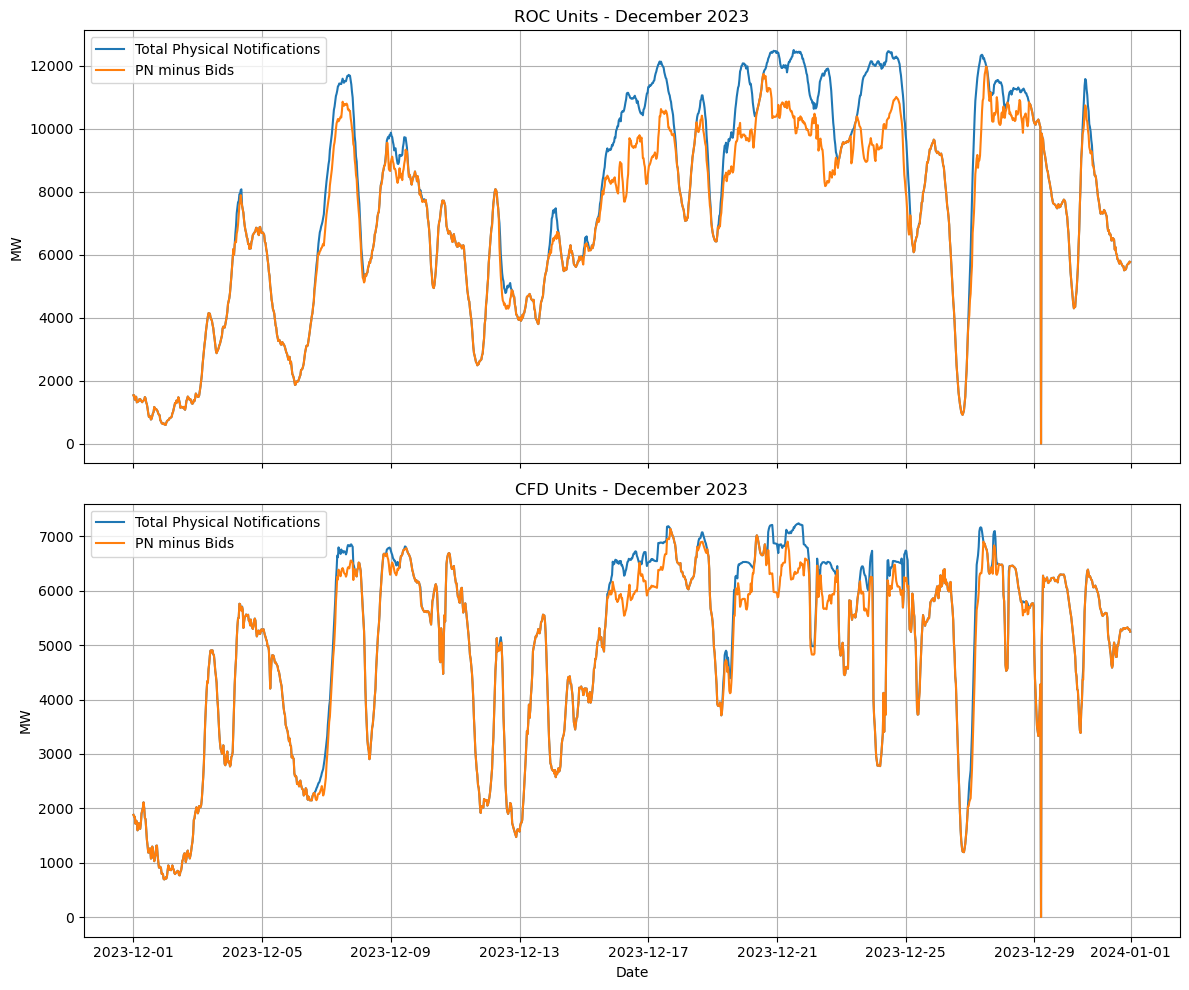

In [36]:
import matplotlib.pyplot as plt

# Set the month to analyze (format: 'YYYY-MM')
analysis_month = '2023-12'  # Change this to analyze different months

# Filter data for the selected month
month_mask = pns_df.index.strftime('%Y-%m').isin([analysis_month])
pns_month = pns_df[month_mask]
bids_month = bids_df[month_mask]

# Extract year and month for title
year_month_str = pd.to_datetime(analysis_month).strftime('%B %Y')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# ROC units analysis
roc_units = roc.index
roc_pns = pns_month.loc[:, pns_month.columns.isin(roc_units)].sum(axis=1)
roc_bids_units = bids_month.loc[:, bids_month.columns.isin(roc_units)].sum(axis=1)

# Ensure indices match for subtraction
roc_bids_reindexed = roc_bids_units.reindex(roc_pns.index, fill_value=0)
roc_pns_minus_bids = roc_pns - roc_bids_reindexed

# Plot ROC units
ax1.plot(roc_pns.index, roc_pns, label='Total Physical Notifications')
ax1.plot(roc_pns.index, roc_pns_minus_bids, label='PN minus Bids')
ax1.set_title(f'ROC Units - {year_month_str}')
ax1.set_ylabel('MW')
ax1.legend()
ax1.grid(True)

# CFD units analysis
cfd_units = cfd.index
cfd_pns = pns_month.loc[:, pns_month.columns.isin(cfd_units)].sum(axis=1)
cfd_bids_units = bids_month.loc[:, bids_month.columns.isin(cfd_units)].sum(axis=1)

# Ensure indices match for subtraction
cfd_bids_reindexed = cfd_bids_units.reindex(cfd_pns.index, fill_value=0)
cfd_pns_minus_bids = cfd_pns - cfd_bids_reindexed

# Plot CFD units
ax2.plot(cfd_pns.index, cfd_pns, label='Total Physical Notifications')
ax2.plot(cfd_pns.index, cfd_pns_minus_bids, label='PN minus Bids')
ax2.set_title(f'CFD Units - {year_month_str}')
ax2.set_xlabel('Date')
ax2.set_ylabel('MW')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
